In [3]:
# todo assuming channels are last (i.e `keras.backend.set_image_data_format('channels_last')`)

In [4]:
from tensorflow.keras import backend as K
K.clear_session()

import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [5]:
import random
import numpy as np
from matplotlib import pyplot as plt

from tifffile import imread

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, Reshape, Dense, multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import minmax_scale
from tensorflow.keras.preprocessing.image import img_to_array, load_img, save_img
from sklearn.model_selection import train_test_split

In [6]:
try:
  from tensorflow.keras.layers.experimental.preprocessing import CenterCrop
  
  print('using tensorflow.keras.layers.experimental.preprocessing.CenterCrop')
except:
  from tensorflow.python.eager import context
  from tensorflow.python.framework import dtypes
  from tensorflow.python.framework import ops
  from tensorflow.python.framework import tensor_shape
  from tensorflow.python.framework import tensor_util
  from tensorflow.python.keras import backend as K
  from tensorflow.python.keras.engine.base_layer import Layer
  from tensorflow.python.keras.engine.input_spec import InputSpec
  from tensorflow.python.keras.utils import tf_utils
  from tensorflow.python.ops import array_ops
  from tensorflow.python.ops import check_ops
  from tensorflow.python.ops import control_flow_ops
  from tensorflow.python.ops import image_ops
  from tensorflow.python.ops import math_ops
  from tensorflow.python.ops import stateful_random_ops
  from tensorflow.python.ops import stateless_random_ops
  from tensorflow.python.ops import variables
  from tensorflow.python.util.tf_export import keras_export

  ResizeMethod = image_ops.ResizeMethod

  H_AXIS = 1
  W_AXIS = 2

  class CenterCrop(Layer):
    """Crop the central portion of the images to target height and width.
    Input shape:
      4D tensor with shape:
      `(samples, height, width, channels)`, data_format='channels_last'.
    Output shape:
      4D tensor with shape:
      `(samples, target_height, target_width, channels)`.
    If the input height/width is even and the target height/width is odd (or
    inversely), the input image is left-padded by 1 pixel.
    Arguments:
      height: Integer, the height of the output shape.
      width: Integer, the width of the output shape.
      name: A string, the name of the layer.
    """

    def __init__(self, height, width, name=None, **kwargs):
      self.target_height = height
      self.target_width = width
      self.input_spec = InputSpec(ndim=4)
      super(CenterCrop, self).__init__(name=name, **kwargs)

    def call(self, inputs):
      inputs_shape = array_ops.shape(inputs)
      img_hd = inputs_shape[H_AXIS]
      img_wd = inputs_shape[W_AXIS]
      img_hd_diff = img_hd - self.target_height
      img_wd_diff = img_wd - self.target_width
      checks = []
      checks.append(
          check_ops.assert_non_negative(
              img_hd_diff,
              message='The crop height {} should not be greater than input '
              'height.'.format(self.target_height)))
      checks.append(
          check_ops.assert_non_negative(
              img_wd_diff,
              message='The crop width {} should not be greater than input '
              'width.'.format(self.target_width)))
      with ops.control_dependencies(checks):
        bbox_h_start = math_ops.cast(img_hd_diff / 2, dtypes.int32)
        bbox_w_start = math_ops.cast(img_wd_diff / 2, dtypes.int32)
        bbox_begin = array_ops.stack([0, bbox_h_start, bbox_w_start, 0])
        bbox_size = array_ops.stack(
            [-1, self.target_height, self.target_width, -1])
        outputs = array_ops.slice(inputs, bbox_begin, bbox_size)
        return outputs

    def compute_output_shape(self, input_shape):
      input_shape = tensor_shape.TensorShape(input_shape).as_list()
      return tensor_shape.TensorShape(
          [input_shape[0], self.target_height, self.target_width, input_shape[3]])

    def get_config(self):
      config = {
          'height': self.target_height,
          'width': self.target_width,
      }
      base_config = super(CenterCrop, self).get_config()
      return dict(list(base_config.items()) + list(config.items()))

  print('using https://github.com/tensorflow/tensorflow/blob/v2.3.1/tensorflow/python/keras/layers/preprocessing/image_preprocessing.py#L121-L184')

using https://github.com/tensorflow/tensorflow/blob/v2.3.1/tensorflow/python/keras/layers/preprocessing/image_preprocessing.py#L121-L184


In [7]:
from configparser import ConfigParser

try:
    from google.colab import files
    
    print('upload `config.ini`')
    uploaded = files.upload()
except:
    print('no colab detected -> reading from local disk')

config = ConfigParser()
config.read('./config.ini')

no colab detected -> reading from local disk


['./config.ini']

In [8]:
import os
from pathlib import Path
import json
import ast

try:
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = Path(config.get('data folder', 'colab'))
except:
  import os
  from pathlib import Path
  here = Path(os.getcwd())
  data_path = here / config.get('data folder', 'taurus')

data_path = data_path.resolve()
out_path = Path(config.get('experiment', 'output folder')).resolve()
experiments_file = out_path / config.get('experiment', 'output file')

In [9]:
def load_tiff(f):
  return imread(f)


def load_image(f):
  return load_tiff(f)


def load_mask(f):
  return load_tiff(f)


def get_data(imgs_path, masks_path):
  list_imgs = [
      f
      for f in imgs_path.iterdir()
      if str(f).endswith('.tif')
  ]
  
  images = []
  masks = []
 
  for img_path in list_imgs:
    img = load_image(img_path).squeeze()
    
    mask_path = str(img_path).replace(str(imgs_path), str(masks_path)).replace('img_', 'mask_')
    mask = load_mask(mask_path)
     
    images.append(np.array(img))
    masks.append(np.array(mask))

  return images, masks

In [10]:
def normalize_transformation(feature_range):
  def _f(x):
    shape = x.shape
    x = minmax_scale(x.ravel(), feature_range=feature_range)
    x = x.reshape(shape)  # original size
    return x
  
  return _f


def crop_center_transformation(shape):
  height, width, *_ = shape  # 3rd dim not needed

  def get_start_point(dim, cropping):
    return dim // 2 - cropping // 2
  
  def get_end_point(start, cropping):
    return start + cropping
  
  def _f(img):
    y, x, *_ = img.shape  # n channels not wanted
    (start_x, start_y) = (get_start_point(x, width), get_start_point(y, height))
    (end_x, end_y) = (get_end_point(start_x, width), get_end_point(start_y, height))
    return img[start_y : end_y, start_x : end_x, ...]
  
  return _f


def rm_percentiles_transformation(min_p=0.0, max_p=100.0):
  def _f(x):
    shape = x.shape
    x = x.ravel()
    new_min, new_max = np.percentile(x, [min_p, max_p])
    x[x < new_min] = new_min
    x[x > new_max] = new_max
    return x.reshape(shape)
  
  return _f


def add_dim():
  def _f(x):
    new_dim_index = len(x.shape)
    x = np.expand_dims(x, new_dim_index)
    return x

  return _f

def compose_transformations(transformations):
  def _f(x):
    for t in transformations:
      x = t(x)
    return x
  
  return _f


def apply_transformations(lst, transformations):
  t = compose_transformations(transformations) 
  return [
    t(x) for x in lst
  ]


def do_transformations(X, y, transformations):
  X = apply_transformations(X, transformations)
  y = apply_transformations(y, transformations)
  return X, y


def parse_data(raw):
  X, y = raw
  img_shape = (config.getint('image', 'width'), config.getint('image', 'height'))
  transformations = [
    np.array,  # just in case parser did not np.array-ed
    rm_percentiles_transformation(1, 98),  # threshold outliers
    normalize_transformation((0, 1)),  # pixel values in [0, 1]
    crop_center_transformation(img_shape),
    add_dim()
  ]
  X, y = apply_transformations(X, transformations), apply_transformations(y, transformations)
  X, y = np.array(X), np.array(y)  # python list -> np.array
  return X, y

In [11]:
X, y = parse_data(
  get_data(
    data_path / config.get('data folder', 'images'),
    data_path / config.get('data folder', 'masks')
  )
)

print('X ~ {}, y ~ {}'.format(X.shape, y.shape))

X ~ (92, 256, 256, 1), y ~ (92, 256, 256, 1)


41

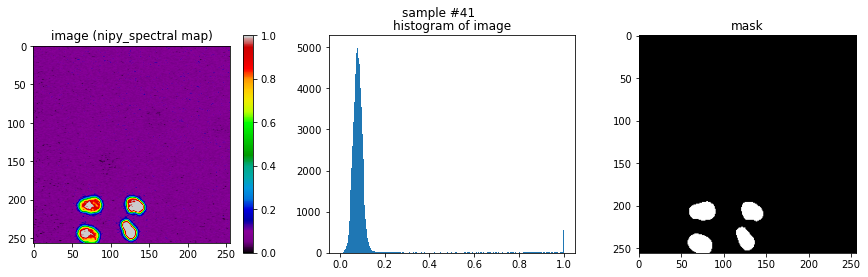

In [12]:
def plot_sample(X, y, ix=None):
  if ix is None:
    ix = random.randint(0, len(X) - 1)

  fig, ax = plt.subplots(1, 3, figsize=(15, 4))

  im = ax[0].imshow(X[ix, ..., 0], cmap=config.get('image', 'cmap'))
  fig.colorbar(im, ax=ax[0])
  ax[0].set_title('image ({} map)'.format(config.get('image', 'cmap')))

  ax[1].hist(X[ix, ...].ravel(), bins=256)
  ax[1].set_title('histogram of image')

  ax[2].imshow(y[ix].squeeze(), cmap='gray')
  ax[2].set_title('mask')

  fig.suptitle('sample #{}'.format(ix))
    
  return ix


plot_sample(X, y)  # check if data looks all right

In [13]:
def se_block(r=16.0):
  def squeeze(x):
    return GlobalAveragePooling2D()(x)
  
  def fc(n_filters, activation):
    def _f(x):
      return Dense(n_filters, activation=activation, use_bias=False)(x)
    
    return _f
  
  def excite(x, n_channels, r):
    # se = Reshape(se_shape)(se)
    x = fc(n_channels // r, 'relu')(x)
    x = fc(n_channels, 'sigmoid')(x)
    return x

  def _f(x):
    n_channels = x.shape[-1]

    inp = x  # save for later
    x = squeeze(x)
    x = excite(x, n_channels, r)
    return multiply([inp, x])
  
  return _f

In [22]:
filter_mult = 2  # todo as arg


def conv2d_block(n_filters, kernel_shape, padding, use_se_block, dropout=0.0, batchnorm=True):
  activation = 'relu'

  def _f(x):
    n_layers = 2  # todo as arg

    for _ in range(n_layers):
      x = Conv2D(n_filters, kernel_shape, padding=padding)(x)
      
      if batchnorm:
        x = BatchNormalization()(x)
      
      x = Activation(activation=activation)(x)
      
      if use_se_block:
        x = se_block()(x)

      if dropout > 0:
        x = Dropout(dropout)(x)

    return x

  return _f


def contracting_block(n_filters, kernel_shape, pool_shape, padding, use_se_block, dropout, batchnorm):
  pooling = MaxPooling2D(pool_shape)

  def _f(x):
    x = conv2d_block(n_filters, kernel_shape, padding, use_se_block, dropout, batchnorm)(x)
    skip_conn = x  # save for expanding path
    x = pooling(x)  # ready for next block
    
    return x, skip_conn

  return _f


def contracting_path(n_filters, n_layers, kernel_shape, pool_shape, use_skip_conn, padding, use_se_block, dropout, batchnorm):
  def _f(x):
    skip_conns = []
    current_n_filters = n_filters

    for _ in range(n_layers):
      x, s = contracting_block(current_n_filters, kernel_shape, pool_shape, padding, use_se_block, dropout, batchnorm)(x)
    
      current_n_filters = int(current_n_filters * filter_mult)
      
      if not use_skip_conn:
        s = None  # not to be used
      
      skip_conns.append(s)

    return x, skip_conns

  return _f


def middle_path(kernel_shape, padding, dropout, batchnorm):
  def _f(x):
    n_filters = int(x.shape[-1] * filter_mult)
    x = conv2d_block(n_filters, kernel_shape, padding, dropout, batchnorm)(x)
    return x

  return _f


def expanding_block(n_filters, skip_conn, kernel_shape, pool_shape, padding, use_se_block, dropout, batchnorm):
  upsampling = UpSampling2D(pool_shape)

  def _f(x):
    if use_se_block:
      x = se_block()(x)
    
    x = upsampling(x)
    using_skip_conn = not (skip_conn is None)
    
    if using_skip_conn:
      s = CenterCrop(x.shape[1], x.shape[2])(skip_conn)
      x = concatenate([x, s])
    
    x = conv2d_block(n_filters, kernel_shape, padding, dropout, batchnorm)(x)
    return x

  return _f


def expanding_path(n_filters, skip_conns, kernel_shape, pool_shape, padding, use_se_block, dropout, batchnorm):
  def _f(x):
    current_n_filters = n_filters

    for skip_conn in reversed(skip_conns):
      x = expanding_block(current_n_filters, skip_conn, kernel_shape, pool_shape, padding, use_se_block, dropout, batchnorm)(x)
      current_n_filters = int(current_n_filters / filter_mult)

    return x

  return _f


def final_path(n_classes, activation, padding, use_se_block):
  def _f(x):
    if use_se_block:
      x = se_block()(x)

    x = Conv2D(n_classes, (1, 1), padding=padding, activation=activation)(x)
    return x

  return _f


def unet_block(n_filters, n_layers, kernel_shape, pool_shape, n_classes, final_activation, padding, use_skip_conn, use_se_block, dropout, batchnorm):
  def _f(x):
    x, skip_conns = contracting_path(n_filters, n_layers, kernel_shape, pool_shape, use_skip_conn, padding, use_se_block, dropout, batchnorm)(x)
    x = middle_path(kernel_shape, padding, dropout, batchnorm)(x)

    current_n_filters = skip_conns[-1].shape[-1] if use_skip_conn else n_filters * filter_mult ** (n_layers - 1)
    x = expanding_path(current_n_filters, skip_conns, kernel_shape, pool_shape, padding, use_se_block, dropout, batchnorm)(x)
    x = final_path(n_classes, final_activation, padding, use_se_block)(x)
    return x

  return _f

In [15]:
def build_unet(n_filters, n_layers, kernel_size, pool_size, n_classes, final_activation, padding='same', use_skip_conn=True, use_se_block=False, dropout=0.0, batchnorm=False):
  n_dim = 2  # todo as arg
  kernel_shape = (kernel_size, ) * n_dim
  pool_shape = (pool_size, ) * n_dim
  
  img_shape = (config.getint('image', 'width'), config.getint('image', 'height'), config.getint('image', 'depth'))  # todo variable-size input
  inp = Input(img_shape)  # save for later
  out = unet_block(
    n_filters,
    n_layers,
    kernel_shape,
    pool_shape,
    n_classes,
    final_activation,
    padding,
    use_skip_conn,
    use_se_block,
    dropout,
    batchnorm
  )(inp)
  
  model = Model(inputs=inp, outputs=out)
  return model

In [16]:
def do_training(model, X_train, X_test, y_train, y_test, best_model_weights_file, batch_size, epochs, callbacks, compile_args):
  verbose = config.getint('experiment', 'verbose')
  
  model.compile(**compile_args)
  results = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=callbacks, validation_data=(X_test, y_test))
  
  return results

def do_inference(model, best_model_weights_file, data, batch_size):
  verbose = config.getint('experiment', 'verbose')
  
  model.load_weights(best_model_weights_file)
  preds_val = model.predict(data, verbose=verbose, batch_size=batch_size)
  return preds_val

In [17]:
def eps_divide(n, d, eps=K.epsilon()):
  """ perform division using eps """
    
  return (n + eps) / (d + eps)


def mean_IoU(y_true, y_pred, threshold=0.5):
  y_pred = K.cast(K.greater(y_pred, threshold), dtype='float32')
  inter = K.sum(K.sum(K.squeeze(y_true * y_pred, axis=3), axis=2), axis=1)  # always 3D images (even if grayscale)
  union = K.sum(K.sum(K.squeeze(y_true + y_pred, axis=3), axis=2), axis=1) - inter
  return K.mean(eps_divide(inter, union))


def DSC(y_true, y_pred, smooth=1.0, threshold=0.5, axis=[1, 2, 3]):
  def _sum(x):
    return K.sum(x, axis=axis)
  
  y_pred = K.cast(K.greater(y_pred, threshold), dtype='float32')
  intersection = _sum(y_true * y_pred)
  union = _sum(y_true) + _sum(y_pred)
  return K.mean(eps_divide(2.0 * intersection, union + smooth, eps=smooth), axis=0)

In [18]:
experiments = [
#   {
#     'use_skip_conn': True,  # obviously
#     'padding': 'same',  # usual
#     'use_se_block': False,  # usual
#     'best_model_weights': 'with_same.h5',
#     'results': None
#   },
#   {
#     'use_skip_conn': False,
#     'padding': 'same',  # usual
#     'use_se_block': False,  # usual
#     'best_model_weights': 'without_same.h5',
#     'results': None
#   },
#   {
#     'use_skip_conn': True,  # obviously
#     'padding': 'valid',
#     'best_model_weights': 'with_valid.h5',
#     'use_se_block': False,  # usual
#     'results': None
#   },
#   {
#     'use_skip_conn': False,
#     'padding': 'valid',
#     'best_model_weights': 'without_valid.h5',
#     'use_se_block': False,  # usual
#     'results': None
#   },
  {
    'use_skip_conn': True,  # obviously
    'padding': 'same',  # usual
    'use_se_block': True,
    'best_model_weights': 'with_same_se.h5',
    'results': None
  },
#   {
#     'use_skip_conn': False,
#     'padding': 'same',  # usual
#     'use_se_block': True,
#     'best_model_weights': 'without_same_se.h5',
#     'results': None
#   },
#   {
#     'use_skip_conn': True,  # obviously
#     'padding': 'valid',
#     'best_model_weights': 'with_valid_se.h5',
#     'use_se_block': True,
#     'results': None
#   },
#   {
#     'use_skip_conn': False,
#     'padding': 'valid',
#     'best_model_weights': 'without_valid_se.h5',
#     'use_se_block': True,
#     'results': None
#   }
]

base_args = {
  'n_filters': config.getint('unet', 'n filters'),
  'n_layers': config.getint('unet', 'n layers'),
  'kernel_size': 3,
  'pool_size': 2,
  'n_classes': 1,  # the other is 1 - ... (because it's a probability distribution)
  'final_activation': config.get('unet', 'final activation'),
  'dropout': config.getfloat('unet', 'dropout'),
  'batchnorm': config.getboolean('unet', 'batchnorm')
}

compile_args = {
  'optimizer': config.get('training', 'optimizer'),
  'loss': config.get('training', 'loss'),
  'metrics': ['accuracy', mean_IoU, DSC]
}

In [19]:
def calc_padding_out_size(n_layers):
  """ calculate output size in a U-Net assuming PADDED (i.e "valid") convolutions """

  def _div_tup(t, y):
    return (x / y for x in t)

  def _mul_tup(t, y):
    return (x * y for x in t)

  def _sub_tup(t, y):
    return (x - y for x in t)

  def _f(x):
    x = _sub_tup(x, 4)  # conv
    
    for _ in range(n_layers):  # contracting path
      x = _sub_tup(x, 4)  # conv
      x = _div_tup(x, 2)  # pool

    x = _sub_tup(x, 4)  # conv

    for _ in range(n_layers):  # expanding path
      x = _mul_tup(x, 2)  # upsample
      x = _sub_tup(x, 4)  # conv
    
    x = tuple(int(_x) for _x in x)
    return x

  return _f


def train_validate_test_split(x, y, valid_size, test_size, *args, **kwargs):
  X_train, X_val, y_train, y_val = train_test_split(
    x, y, test_size=valid_size + test_size, *args, **kwargs
  )
  test_size = test_size / (test_size + valid_size)  # wrt to valid
  X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=test_size, **kwargs
  )
  return X_train, X_val, X_test, y_train, y_val, y_test


def prepare_data(X, y, experiment, verbose=False):
  if experiment['padding'] == 'valid':  # we have to reduce size of output (i.e y)
    img_shape = X.shape[1: 2 + 1]  # width, height of input images
    img_out_shape = calc_padding_out_size(config.getint('unet', 'n layers'))(img_shape)
    output_shape = (*img_out_shape, config.getint('image', 'depth'))
    
    transformations = [
      crop_center_transformation(output_shape),
    ]
    y = apply_transformations(y, transformations)  # reduce output size
    y = np.array(y)

  X_train, X_val, X_test, y_train, y_val, y_test = train_validate_test_split(
    X, y, config.getfloat('experiment', 'val size'), config.getfloat('experiment', 'test size'), random_state=11
  )
  
  if verbose:
    print('=== experiment {}'.format(experiment['best_model_weights']))
    print('- training: X ~ {}, y ~ {}'.format(X_train.shape, y_train.shape))
    print('- validation: X ~ {}, y ~ {}'.format(X_val.shape, y_val.shape))
    print('- test: X ~ {}, y ~ {}'.format(X_test.shape, y_test.shape))
  
  return X_train, X_val, X_test, y_train, y_val, y_test

In [23]:
for experiment in experiments:
  X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(X, y, experiment, verbose=True)
  
  args = {
    **base_args,
    'padding': experiment['padding'],
    'use_skip_conn': experiment['use_skip_conn']
  }

  verbose = config.getint('experiment', 'verbose')
  model_file = str(out_path / experiment['best_model_weights'])
  callbacks = [
    EarlyStopping(patience=10, verbose=verbose),
    ReduceLROnPlateau(factor=1e-1, patience=3, min_lr=1e-5, verbose=verbose),
    ModelCheckpoint(model_file, monitor='loss', verbose=verbose, save_best_only=True, save_weights_only=True)
  ]

  model = build_unet(**args)
  results = do_training(
    model,
    X_train,
    X_val,
    y_train,
    y_val,
    experiment['best_model_weights'],
    config.getint('training', 'batch size'),
    config.getint('training', 'epochs'),
    callbacks,
    compile_args
  )
  experiment['history'] = results.history

=== experiment with_same_se.h5
- training: X ~ (73, 256, 256, 1), y ~ (73, 256, 256, 1)
- validation: X ~ (9, 256, 256, 1), y ~ (9, 256, 256, 1)
- test: X ~ (10, 256, 256, 1), y ~ (10, 256, 256, 1)
Train on 73 samples, validate on 10 samples
Epoch 1/10
72/73 [============================>.] - ETA: 0s - loss: 0.2254 - accuracy: 0.9571 - mean_IoU: 0.7227 - DSC: 0.8077
Epoch 00001: loss improved from inf to 0.22384, saving model to /home/h4/stfo194b/scratch/attila/unet/out/with_same_se.h5
73/73 [==============================] - 21s 293ms/sample - loss: 0.2238 - accuracy: 0.9575 - mean_IoU: 0.7274 - DSC: 0.8123 - val_loss: 52.2794 - val_accuracy: 0.0538 - val_mean_IoU: 0.0540 - val_DSC: 0.1018
Epoch 2/10
72/73 [============================>.] - ETA: 0s - loss: 0.0690 - accuracy: 0.9947 - mean_IoU: 0.9039 - DSC: 0.9489
Epoch 00002: loss improved from 0.22384 to 0.06885, saving model to /home/h4/stfo194b/scratch/attila/unet/out/with_same_se.h5
73/73 [==============================] - 9s 126

In [125]:
def save_experiments(experiments):
  with open(experiments_file, 'w') as fp:
    json.dump(str(experiments), fp)
      

def load_experiments():
  with open(experiments_file, 'r') as fp:
    experiments = ast.literal_eval(json.load(fp))
    return experiments

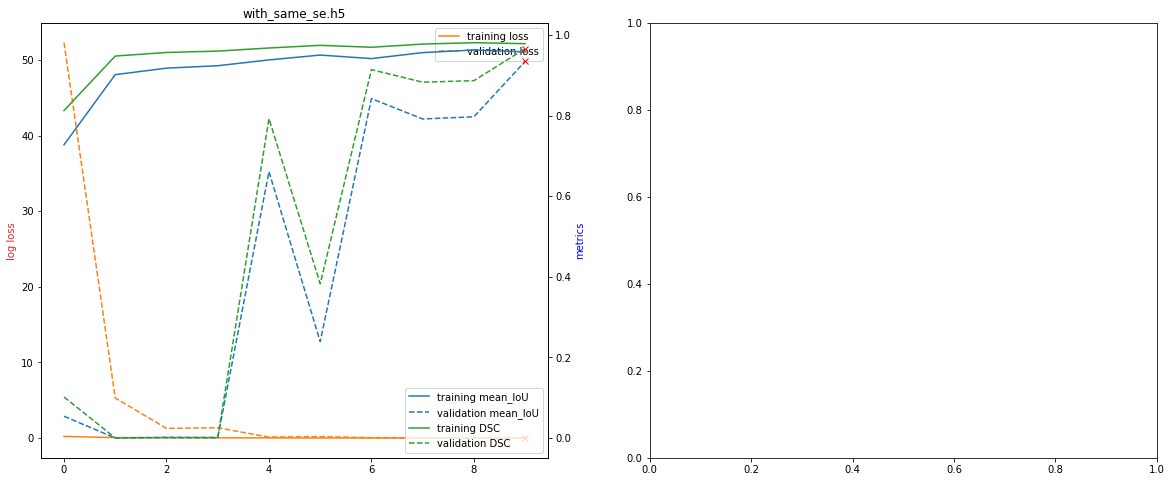

In [26]:
def plot_history(experiments, last=None):
  if last is None:
    last = 0
  
  n_cols = 2
  n_rows = int(np.floor(len(experiments) / n_cols) + 1)
  fig, axis = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
  
  def _plot_key_results(ax, key, results, color, find_min=False, find_max=False):
      training = results[key]
      validation = results['val_{}'.format(key)]
    
      ax.plot(training, label='training {}'.format(key), color=color)
      ax.plot(validation, '--', label='validation {}'.format(key), color=color)
      
      if find_min:
        ax.plot(np.argmin(validation), np.min(validation), marker='x', color='r')
        
      if find_max:
        ax.plot(np.argmax(validation), np.max(validation), marker='x', color='r')
    
  def _plot_results(results, ax):
      _plot_key_results(ax, 'loss', results, 'C1', find_min=True)  # see https://matplotlib.org/3.1.1/users/dflt_style_changes.html
      ax.set_ylabel('log loss', color='C3')
      ax.legend()

      ax = ax.twinx()  # instantiate a second axes that shares the same x-axis

      _plot_key_results(ax, 'mean_IoU', results, 'C0', find_max=True)
      _plot_key_results(ax, 'DSC', results, 'C2', find_max=True)
      
      ax.set_ylabel('metrics', color='b')
      ax.legend()

      ax.set_title(experiment['best_model_weights'])

  for ax, experiment in zip(axis.ravel(), experiments):
      history = experiment['history']
      results = {
        k: history[k][-last:]
        for k in history.keys()
      }
      
      _plot_results(results, ax)
    

plot_history(experiments, last=45)

In [ ]:
def plot_sample(X, y, pred, model_name, ix=None):
  if ix is None:
    ix = random.randint(0, len(X) - 1)

  fig, ax = plt.subplots(1, 2, figsize=(10, 4))
  ax[0].imshow(X[ix, ..., 0], cmap=config.get('image', 'cmap'))
  ax[0].set_title('original image')
  
  ax[1].imshow(pred[ix].squeeze(), cmap='gray')
  ax[1].contour(y[ix].squeeze(), colors='yellow', levels=[0.5])
  ax[1].set_title('{} (ground truth mask as contour)'.format(experiment['best_model_weights']))

  fig.suptitle('sample #{} from {}'.format(ix, model_name))
    
  return ix


# def do_evaluation(X_test, y_test, model, model_file):
#   pred = do_inference(model, model_file, X_test, config.getint('training', 'batch size'))


for i, experiment in enumerate(experiments):
  _, _, X_test, _, _, y_test = prepare_data(X, y, experiment, verbose=False)
  
  args = {
    **base_args,
    'padding': experiment['padding'],
    'use_skip_conn': experiment['use_skip_conn']
  }
  model = get_unet(**args)
  model_file = str(experiments_path / experiment['best_model_weights'])
  experiments[i]['pred'] = do_inference(model, model_file, X_test, config.getint('training', 'batch size'))
  plot_sample(X_test, y_test, experiments[i]['pred'], experiment['best_model_weights'])
  

save_experiments(experiments)